In [3]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

In [4]:
DATA_ROOT='../data/results-filter-pushdown/sampling/'

In [5]:
modes = sorted(list(map(lambda path: os.path.basename(path), glob.glob(DATA_ROOT + '/*'))))
modes

['A', 'B', 'C', 'D', 'E', 'F', 'hyper']

In [6]:
# load into dataframe for analysis

In [20]:
rows = []
for mode in modes:
    print('>> loading {}'.format(mode))
    row = {'mode' : mode}
    
    # there should be 11 logs in there
    for run in range(11):
        path = os.path.join(DATA_ROOT, mode, 'log-run-{}.txt'.format(run + 1))
        json_path = os.path.join(DATA_ROOT, mode, 'job/job_{:04d}.json'.format(run))
       
        # load each and add data
        row['run'] = run 
        row['path'] = path if os.path.isfile(path) else None
        row['json_path'] = json_path if os.path.isfile(json_path) else None
        
        # read time
        try:
            with open(path, 'r') as fp:
                lines = fp.readlines()
                line = list(filter(lambda line: line.startswith('{"startupTime":'), lines))[0]
                d = json.loads(line.strip())
                row['job_time'] = d['jobTime']
        except:
            row['job_time'] = None
        
        # analyze paths & times
        try:
            with open(json_path, 'r') as fp:
                data = json.load(fp)
                
                in_normal = data['input_paths_taken']['normal']
                in_general = data['input_paths_taken']['general']
                in_fallback = data['input_paths_taken']['fallback']
                in_unresolved = data['input_paths_taken']['unresolved']

                out_normal = data['output_paths_taken']['normal']
                out_unresolved = data['output_paths_taken']['unresolved']

                requests = data['requests']
                
                timings = dict(zip(['t_fast', 't_slow', 't_hyper', 't_compile', 't_fast_per_row'],
                                [0, 0, 0, 0, 0]))
                num_reqs_with_normal = 0
                for req in requests:
                    for k in ['t_fast', 't_slow', 't_hyper', 't_compile']:
                        timings[k] += req.get(k, None)
                    r_in_normal = req['input_paths_taken']['normal']
                    if 0 != r_in_normal:
                        timings['t_fast_per_row'] += req['t_fast'] / r_in_normal
                        num_reqs_with_normal += 1
                        
                row['in_normal'] = in_normal
                row['in_general'] = in_general
                row['in_fallback'] = in_fallback
                row['in_unresolved'] = in_unresolved
                row['out_normal'] = out_normal
                row['out_unresolved'] = out_unresolved
                
                timings['t_fast_per_row'] /= num_reqs_with_normal
                row.update(timings)

        except:
            pass
        
        
        rows.append(row)
        
df = pd.DataFrame(rows)

>> loading A
>> loading B
>> loading C
>> loading D
>> loading E
>> loading F
>> loading hyper


In [21]:
# exclude failed jobs (need to fix those later)
expected_normal_out = 294182

In [22]:
df_ok = df[df['out_normal'] == expected_normal_out]

In [23]:
df_ok.head()

,mode,run,path,json_path,job_time,in_normal,in_general,in_fallback,in_unresolved,out_normal,out_unresolved,t_fast,t_slow,t_hyper,t_compile,t_fast_per_row
0,A,10,../data/results-filter-pushdown/sampling/A/log...,../data/results-filter-pushdown/sampling/A/job...,25.385335,24072,8813133,2175176,0,294182,0,801.110641,1016.79242,0.0,9.021852,0.000053
1,A,10,../data/results-filter-pushdown/sampling/A/log...,../data/results-filter-pushdown/sampling/A/job...,25.385335,24072,8813133,2175176,0,294182,0,801.110641,1016.79242,0.0,9.021852,0.000053
2,A,10,../data/results-filter-pushdown/sampling/A/log...,../data/results-filter-pushdown/sampling/A/job...,25.385335,24072,8813133,2175176,0,294182,0,801.110641,1016.79242,0.0,9.021852,0.000053
3,A,10,../data/results-filter-pushdown/sampling/A/log...,../data/results-filter-pushdown/sampling/A/job...,25.385335,24072,8813133,2175176,0,294182,0,801.110641,1016.79242,0.0,9.021852,0.000053
4,A,10,../data/results-filter-pushdown/sampling/A/log...,../data/results-filter-pushdown/sampling/A/job...,25.385335,24072,8813133,2175176,0,294182,0,801.110641,1016.79242,0.0,9.021852,0.000053


In [24]:
print('{}/{} runs not ok'.format(len(df) - len(df_ok), len(df)))

0/77 runs not ok


Text(0, 0.5, 'end-to-end time in s')

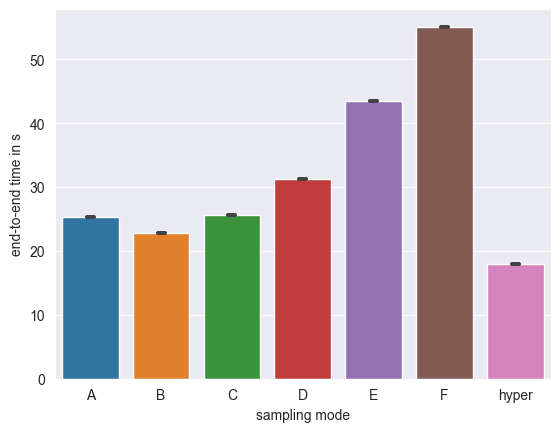

In [25]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='job_time', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('end-to-end time in s')

Text(0, 0.5, '#normal rows')

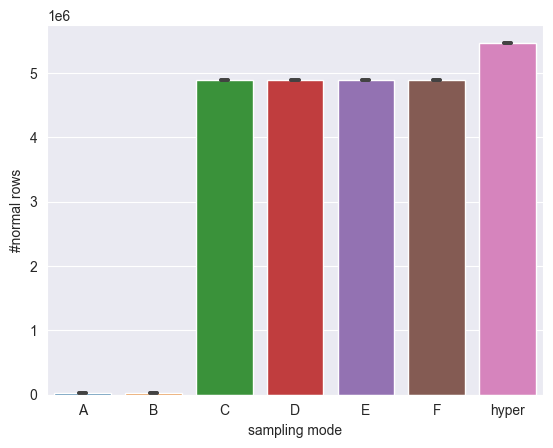

In [26]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_normal', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#normal rows')

Text(0, 0.5, '#general rows')

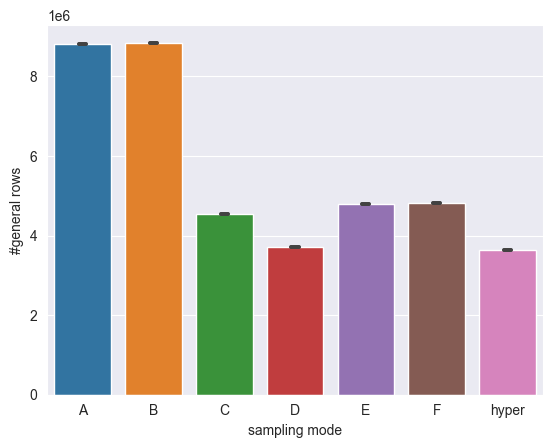

In [27]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_general', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#general rows')

Text(0, 0.5, '#fallback rows')

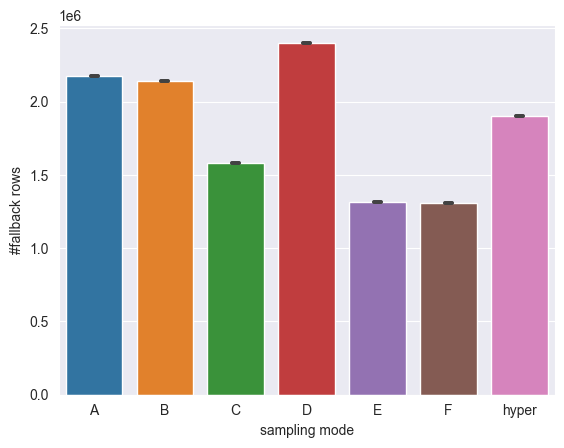

In [28]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='in_fallback', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#fallback rows')

Note that general-case for hyper is the same as in A/B to keep sampling cost on driver cheap.

(700.0, 850.0)

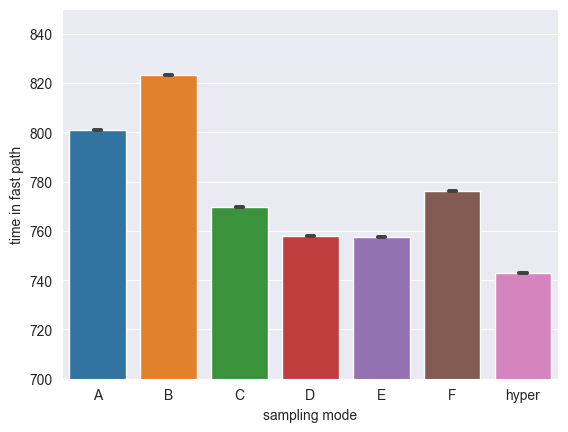

In [29]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_fast', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in fast path')
plt.ylim(700, 850)

Text(0, 0.5, 'time in slow (general + interpreter) path')

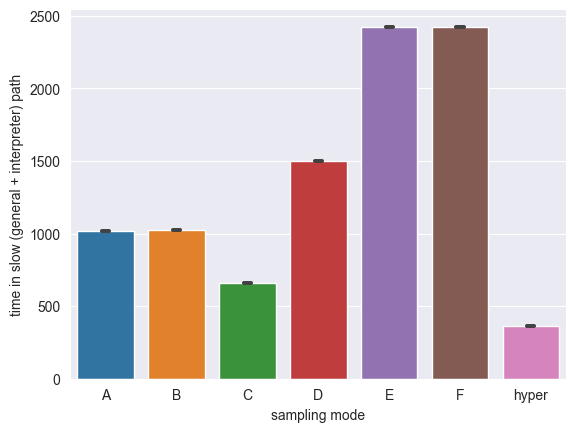

In [30]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_slow', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in slow (general + interpreter) path')

Text(0, 0.5, 'time spend compiling')

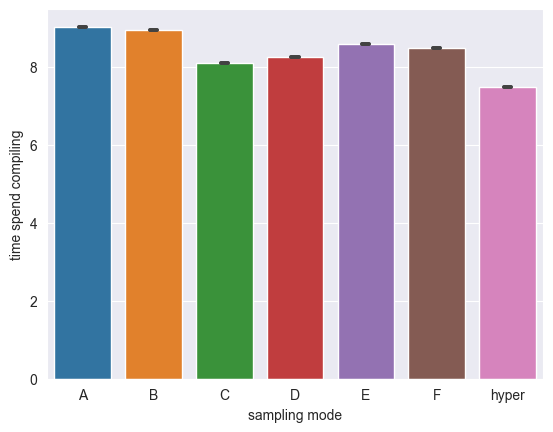

In [31]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_compile', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend compiling')

Text(0, 0.5, 'time spend hyperspecializing')

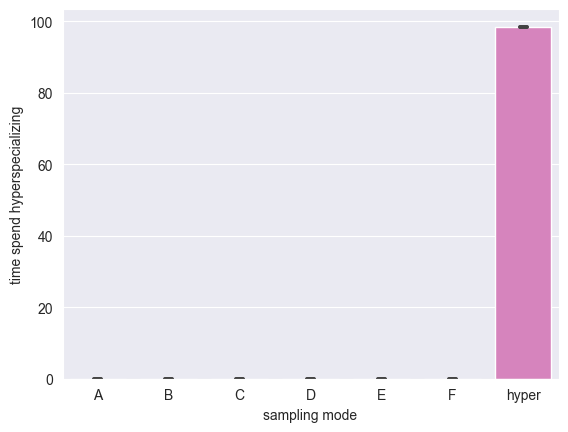

In [32]:
sns.set_style('darkgrid')
sns.barplot(data=df_ok, x='mode', y='t_hyper', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend hyperspecializing')

TODOs:
    
    - filter promo
    - projections pushdown
    - compare for single file our fallback vs. another framework